In [1]:
print('Clustering of human retina dataset')

Clustering of human retina dataset


In [4]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})

In [5]:
#Load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [6]:
adata


AnnData object with n_obs × n_vars = 203066 × 60623
    var: 'gene_id', 'gene_name'

In [7]:
#Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [8]:
#Defining cell & gene counts
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

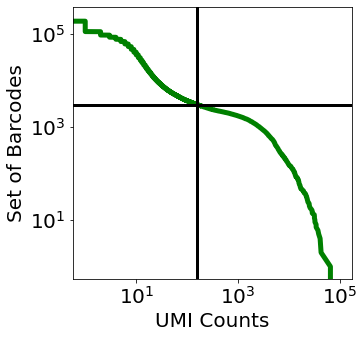

In [9]:
#Threshold cells according to knee plot
expected_num_cells = 3000
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

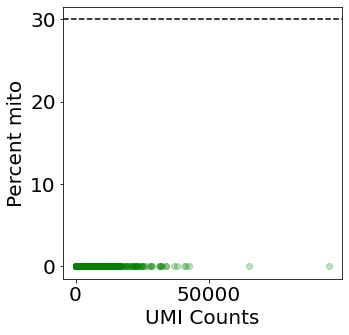

In [10]:
#Comparing UMI counts x Mito percentage
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

In [11]:
#Defining filtering character from parameters above
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [12]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [13]:
#Cell number before and after filtering
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 203,066 cells x 60,623 genes
    New shape: 3,632 cells x 27,184 genes


In [15]:
data = adata[cell_mask, gene_mask]

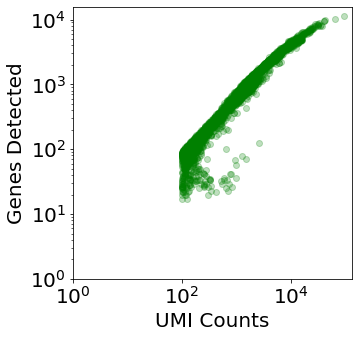

In [16]:
#Library saturation plot showing genes detected as a function of UMI counts
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(data.X.sum(axis=1))
y = nd(np.sum(data.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

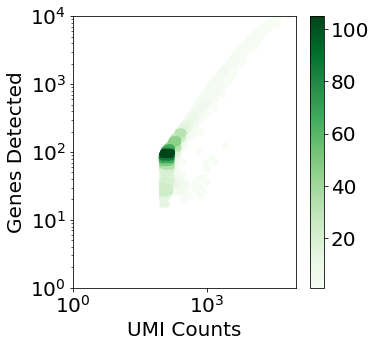

In [17]:
c
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

In [18]:
data

View of AnnData object with n_obs × n_vars = 3632 × 27184
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


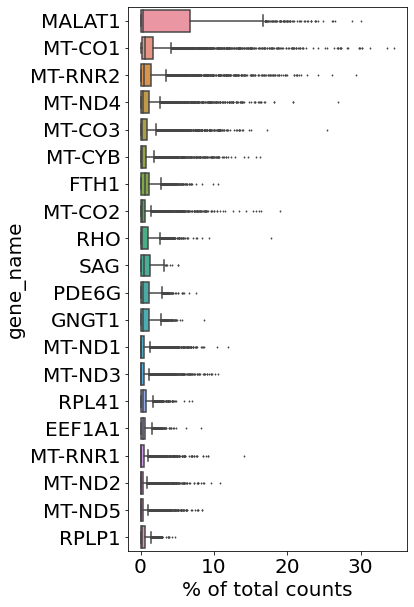

In [19]:
#Top expressed genes across the dataset
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

In [20]:
#Setup

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

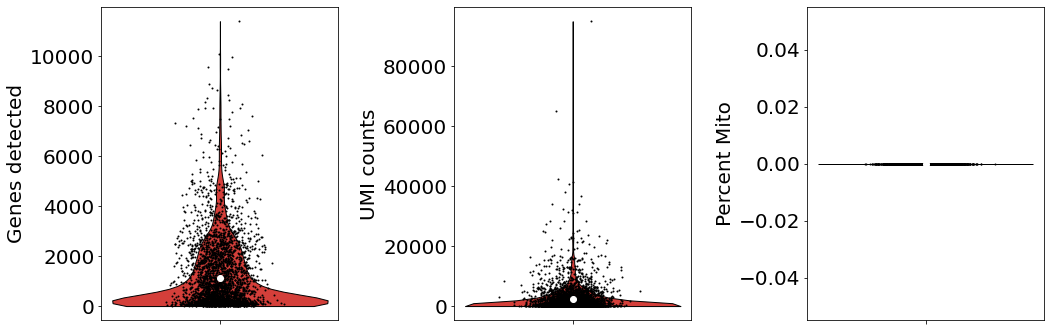

In [21]:
#Plotting distributions
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

In [22]:
#Processing the matrix for clustering and visualisations

In [23]:
data.layers["raw"] = data.X

In [24]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [25]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [26]:
data.X = data.layers["log1p"]

In [27]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

In [28]:
#Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

In [29]:
#PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

In [30]:
#Clustering
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [31]:
sc.tl.leiden(data, random_state=state)

In [32]:
# t-SNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [33]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [35]:
# t-SNE the NCA projection
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

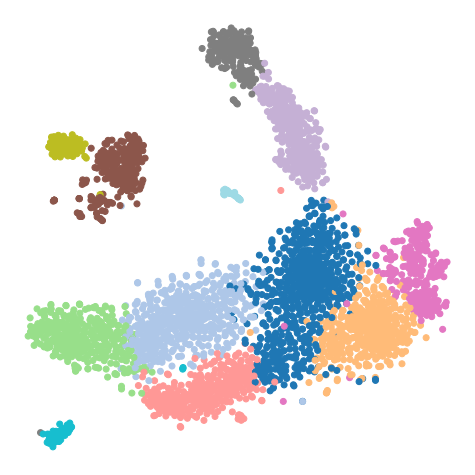

<Figure size 432x288 with 0 Axes>

In [36]:
#PCA followed by t-SNE
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.savefig('figures/PCA_t_SNE.png')

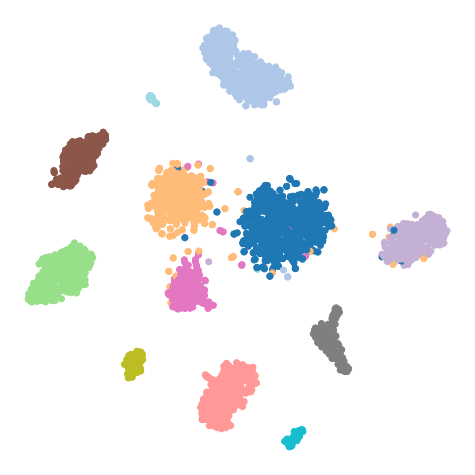

<Figure size 432x288 with 0 Axes>

In [37]:
#NCA followed by t-SNE
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.savefig('figures/NCA_t_SNE.png')

... storing 'gene_name' as categorical


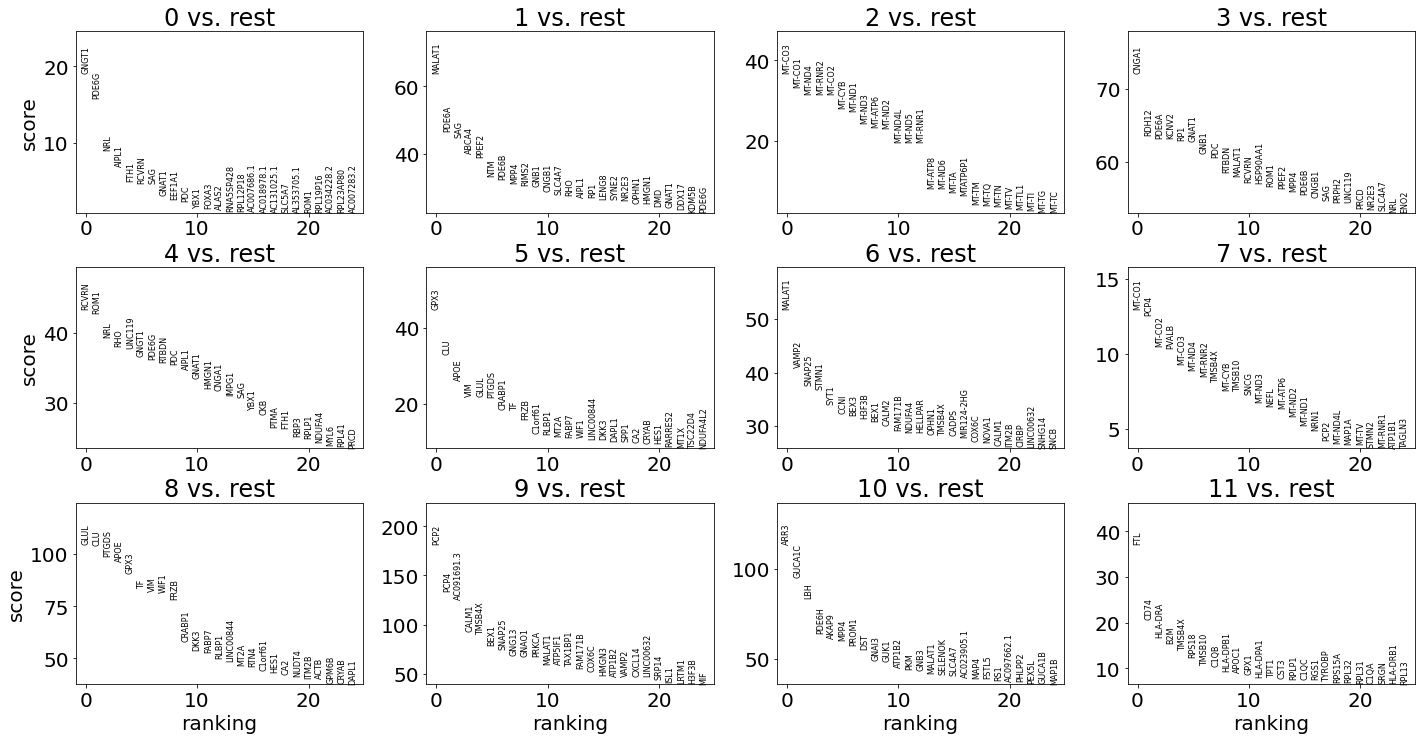

In [38]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [39]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")

In [40]:
#Display top 10 ranked genes per cluster in a dataframe
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,GNGT1,MALAT1,MT-CO3,SAG,ROM1,GPX3,FAM171B,MT-CO1,WIF1,AC091691.3,ARR3,CD74
1,PDE6G,PPEF2,MT-ND4,NR2E3,PDE6G,CLU,CADPS,MT-CO2,TF,PCP2,GUCA1C,FTL
2,FTH1,ABCA4,MT-CO1,RDH12,RHO,APOE,MALAT1,MT-CO3,FRZB,PRKCA,PDE6H,HLA-DRA
3,NRL,NTM,MT-RNR2,KCNV2,RCVRN,GLUL,NOVA1,MT-RNR2,PTGDS,CXCL14,GNAI3,B2M
4,EEF1A1,MPP4,MT-CO2,HSP90AA1,GNGT1,VIM,STMN1,MT-ND4,DKK3,GNAO1,AC023905.1,TMSB4X
5,AIPL1,PDE6B,MT-CYB,PPEF2,IMPG1,PTGDS,CCNI,MT-CYB,GLUL,ISL1,PEX5L,C1QB
6,RPL41,RIMS2,MT-ND1,ELOVL4,NRL,TF,BEX1,PCP4,HES1,CALM1,GNB3,TMSB10
7,RPL3,PDE6A,MT-ND3,MPP4,RTBDN,CRABP1,BEX3,MT-ND3,FABP7,TAX1BP1,GNGT2,RPS18
8,RPLP1,LENG8,MT-ND2,LAPTM4B,UNC119,FRZB,CLTB,MT-ATP6,VIM,GNG13,LBH,TPT1
9,RPS28,NR2E3,MT-ATP6,KCNJ14,GNAT1,GAPDH,HPCA,MT-ND1,CLU,LINC00632,TDRG1,HLA-DPB1


In [41]:
#Creating table with the marker genes, p-values & clusters
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [42]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [43]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [44]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [45]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

,leiden,gene_name,p_value
0,0,GNGT1,5.14086e-93
27184,1,MALAT1,1.11329e-163
54368,2,MT-CO3,3.3297e-189
81552,3,SAG,1.03767e-119
108736,4,ROM1,3.76239e-130
135920,5,GPX3,7.26259e-148
163104,6,FAM171B,6.11602e-93
190288,7,MT-CO1,9.88948e-63
217472,8,WIF1,9.42816e-107
244656,9,AC091691.3,1.00988e-63


In [46]:
def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

In [47]:
specific_cluster = markers_gene.drop_duplicates(["leiden"])["leiden"].values
specific_gene = markers_gene.drop_duplicates(["leiden"])["gene_name"].values

In [48]:
unique

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='<U21')

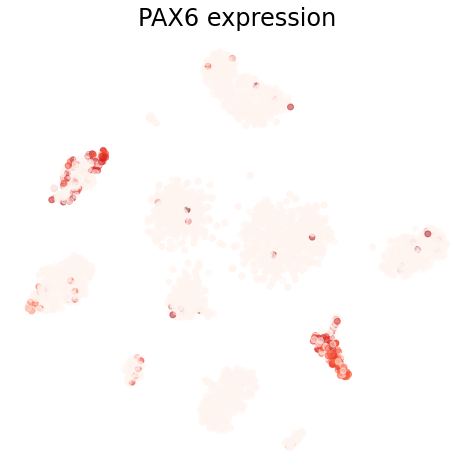

In [50]:
#Visualise expression of specific marker gene
gene = "PAX6"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

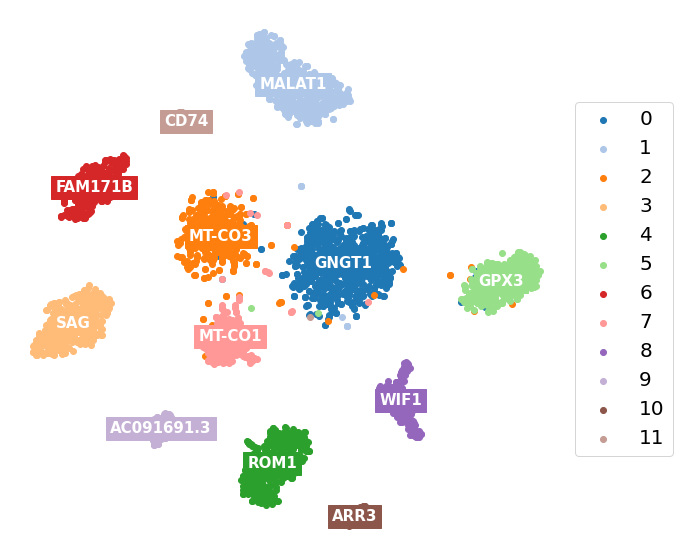

In [51]:
#Annotate clusters
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(data.obs["leiden"].values.astype(int)).astype(str)
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = data[data.obs.leiden == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()